In [18]:
# https://towardsdatascience.com/how-to-use-the-staple-algorithm-to-combine-multiple-image-segmentations-ce91ebeb451e
# packages
import nibabel as nib # https://nipy.org/nibabel/
import SimpleITK as sitk # https://simpleitk.org/
from matplotlib import pyplot as plt
import os
from meidic_vtach_utils.run_on_recommended_cuda import get_cuda_environ_vars as get_vars
os.environ.update(get_vars(select="*"))
from collections import OrderedDict
from mdl_seg_class.metrics import dice3d
import torch
import numpy as np
from tqdm.notebook import trange, tqdm
from ants.segmentation.joint_label_fusion import joint_label_fusion
from ants.utils.convert_nibabel import nifti_to_ants
import pandas as pd


### Recommended gpus on this machine (descending order) ###
  ID  Card name      Util    Mem free  Cuda             User(s)
----  -----------  ------  ----------  ---------------  ---------
   0  TITAN RTX       0 %   24199 MiB  11.2(460.73.01)  root

Will apply following mapping

  ID  Card name        torch
----  -----------  --  -------
   0  TITAN RTX    ->  cuda:0


## Calc deeds STAPLE scores (not used anymore, futher down scores and consensi are generate from the LRASPP training output directly. This ensures data consistency)

In [4]:
# Load all 1800 registered labels
REG_DATA_PATH = "/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/20220114_crossmoda_multiple_registrations/crossmoda_deeds_registered.pth"
bare_data = torch.load(REG_DATA_PATH)

EVERY = 1
staple_filter = sitk.STAPLEImageFilter()
# sitk.ProcessObject.SetGlobalDefaultDebugOff()
FOREGROUND = 1.0
staple_filter.SetMaximumIterations(200) # Do not forget this, otherwise staple runs forever
staple_filter.SetForegroundValue(FOREGROUND)

weight_data = {}
DEBUG = False

for fixed_id, moving_dict in bare_data.items():
    # if fixed_id != '111l': continue
    print(fixed_id)
    # print(moving_dict)
    sorted_moving_dict = OrderedDict(moving_dict)
    moving_data = []
    selected_moving_ids = []
    
    for idx_mov, (moving_id, moving_sample) in enumerate(sorted_moving_dict.items()):
        # Only use every third warped sample
        print(idx_mov)
        # idx_mov = 29
        if idx_mov % EVERY == 0:
            moving_data.append(moving_sample['warped_label'].cpu())
            moving_slice_id = f"{fixed_id}:m{moving_id}"
            selected_moving_ids.append(moving_slice_id)

    sitk_moving_data = [sitk.GetImageFromArray(reg_seg.to_dense().numpy().astype(np.int16)) for reg_seg in moving_data]
    staple_out = staple_filter.Execute(sitk_moving_data)
    # staple_out = sitk.STAPLE(sitk_moving_data, FOREGROUND) # alternative, if no staple filter instance is used
    staple_consensus = sitk.GetArrayFromImage(staple_out)
    
    specitivity = staple_filter.GetSpecificity()
    sensitivity = staple_filter.GetSensitivity()
    print("iters", staple_filter.GetElapsedIterations())

    for moving_id, sens, spec in zip(selected_moving_ids, sensitivity, specitivity):
        weight_data[moving_id] = dict(sensitivity=sens, specitivity=spec)

    if DEBUG: break

torch.save(weight_data, f"../data/staple_calc/deeds_stapled_every_{EVERY}_3d_volumes.pth")


108r
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
iters 26
111l
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
iters 26
112r
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
iters 30
115l
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
iters 27
118r
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
iters 20
120r
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
iters 46
117l
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
iters 20
123r
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
iters 17
127r
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
iters 26
125l
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
iters 19
134r
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21

In [ ]:
# Print sensitivity histogram
dps = []
for key in weight_data.keys():
    if key == 'data_path': continue
    if np.isnan(weight_data[key]['sensitivity']):
        pass
    else:
        dps.append(weight_data[key]['sensitivity'])
plt.hist(dps)

# Process grouped STAPLED samples

### Store STAPLE single rater scores (grouped stapled command line data from mattias)

In [ ]:
from glob import glob
import re

staple_weights = None
staple_description_files = glob("/share/data_supergrover1/heinrich/crossmoda_deeds/Fcrossmoda_*_L_staple*.txt")

target_t2_keys_w_tumour = ['108r', '111l', '112r', '115l', '118r', '120r', '117l', '123r', '127r', '125l', '134r', '135r', '126l', '142r', '144r', '133l', '148r', '154r', '136l', '160r', '165r', '140l', '166r', '167r', '141l', '168r', '171r', '143l', '173r', '174r', '145l', '179r', '146l', '180r', '181r', '185r', '147l', '195r', '149l', '198r', '204r', '152l', '205r', '209r', '158l', '210r', '162l', '164l', '175l', '177l', '178l', '183l', '187l', '188l', '189l', '190l', '192l', '199l', '200l', '202l']
source_t1_keys_w_tumour = ['100r', '101r', '102l', '103l', '104l', '105l', '010l', '011r', '012r', '013l', '014l', '015l', '016r', '017r', '018l', '019r', '001r', '020l', '021l', '022l', '023r', '024r', '025r', '026l', '027r', '028l', '029r', '002l', '030r', '031l', '032r', '033r', '034l', '035r', '036r', '037r', '038l', '039r', '003r', '040r', '041l', '042l', '042r', '043l', '044r', '045r', '046r', '047r', '048r', '049l', '004r', '050r', '051l', '052r', '053r', '054r', '055l', '056l', '057r', '058l', '059r', '005r', '060r', '061l', '062l', '063l', '064l', '065r', '066l', '067l', '068r', '069l', '006r', '070r', '071l', '072r', '073r', '074r', '075l', '076r', '077r', '078r', '079l', '007r', '080r', '081l', '082r', '083r', '084r', '085r', '086r', '087l', '088l', '089l', '008l', '090l', '091r', '092r', '093l', '094r', '095r', '096r', '097r', '098r', '099l', '099r', '009r']

def get_num_lr_id(num_str):
    num_str = int(num_str)
    if f"{num_str:03d}r" in source_t1_keys_w_tumour:
        _id_str = f"{num_str:03d}r"
    elif f"{num_str:03d}l" in source_t1_keys_w_tumour:
        _id_str = f"{num_str:03d}l"
    elif f"{num_str:03d}r" in target_t2_keys_w_tumour:
        _id_str = f"{num_str:03d}r"
    elif f"{num_str:03d}l" in target_t2_keys_w_tumour:
        _id_str = f"{num_str:03d}l"
    return _id_str

def get_rater_dict(fixed_id, moving_id, rater_id):
    fixed_id_dict = consensus_description_dict.get(fixed_id, {}) 
    moving_id_dict = fixed_id_dict.get(moving_id, {})
    rater_dict = moving_id_dict.get(f"rater_{int(rater_id):03d}", {})
    return rater_dict

def set_rater_dict(consensus_description_dict, rater_dict, fixed_id, moving_id, rater_id):
    fixed_id_dict = consensus_description_dict.get(fixed_id, {})
    fixed_id_dict[moving_id] = rater_dict
    consensus_description_dict[fixed_id] = fixed_id_dict

consensus_description_dict = {}

for _file in staple_description_files:
    for staple_split in ['01','23','45','689']:
        result = re.findall(rf'/share/data_supergrover1/heinrich/crossmoda_deeds/Fcrossmoda_(\w+)_L_staple{staple_split}\.txt', _file)
        if not result: 
            continue
        else:
            intra_file_dict = {}
            with open(_file, 'r') as description:
                for line in description:
                    # print(line)
                    seg_info = re.findall(rf'Reading #([0-9]+) from (Fcrossmoda_(\w+)_L_M(\w+)_deformed_seg\.nii\.gz)', line)
                    if seg_info:
                        rater_id, seg_path, fixed_id, moving_id = seg_info[0]
                        fixed_id, moving_id = get_num_lr_id(fixed_id), get_num_lr_id(moving_id)
                        # print(fixed_id, moving_id)
                        rater_dict = get_rater_dict(fixed_id, moving_id, rater_id)
                        rater_dict['file'] = seg_path
                        rater_dict['fixed_id'] = fixed_id
                        rater_dict['moving_id'] = moving_id
                        intra_file_dict[int(rater_id)-1] = rater_dict

                        set_rater_dict(consensus_description_dict, rater_dict, fixed_id, moving_id, rater_id)

                    rater_info = re.findall(rf'Rater ([0-9]+): Sensitivity = ([\.\-\w]+); Specificity = ([\.\w]+)', line)
                    if rater_info:
                        score_rater_id, sensitivity, specitivity = rater_info[0]

                        score_rater_dict = intra_file_dict[int(score_rater_id)]
                        score_fixed_id = score_rater_dict['fixed_id']
                        score_moving_id = rater_dict['moving_id']
                        score_rater_dict['sensitivity'] = float(sensitivity)
                        score_rater_dict['specitivity'] = float(specitivity)
                        set_rater_dict(consensus_description_dict, score_rater_dict, score_fixed_id, score_moving_id, score_rater_id)
                        # print(rater_id, sensitivity, specitivity)
print(consensus_description_dict.keys())

torch.save(consensus_description_dict, "../data/staple_calc/crossmoda_grouped_staple_consensus_text_dict.pth")

### Store STAPLED samples (data from mattias, store stapled hard drive labels into dict)

In [ ]:
from glob import glob
import re
import nibabel as nib
staple_descri = glob("/share/data_supergrover1/heinrich/crossmoda_deeds/Fcrossmoda_*_L_staple*.nii.gz")
stapled_files = glob("/share/data_supergrover1/heinrich/crossmoda_deeds/Fcrossmoda_*_L_staple*.nii.gz")

staple_dict = {}
target_t2_keys_w_tumour = ['108r', '111l', '112r', '115l', '118r', '120r', '117l', '123r', '127r', '125l', '134r', '135r', '126l', '142r', '144r', '133l', '148r', '154r', '136l', '160r', '165r', '140l', '166r', '167r', '141l', '168r', '171r', '143l', '173r', '174r', '145l', '179r', '146l', '180r', '181r', '185r', '147l', '195r', '149l', '198r', '204r', '152l', '205r', '209r', '158l', '210r', '162l', '164l', '175l', '177l', '178l', '183l', '187l', '188l', '189l', '190l', '192l', '199l', '200l', '202l']

for _file in stapled_files:
    for staple_split in ['01','23','45','689']:
    # result = re.findall(r'/share/data_supergrover1/heinrich/crossmoda_deeds/Fcrossmoda_(\w+)_L_staple([0-9]+)\.nii\.gz', _file)
        result = re.findall(rf'/share/data_supergrover1/heinrich/crossmoda_deeds/Fcrossmoda_(\w+)_L_staple{staple_split}\.nii\.gz', _file)
        if not result: 
            continue
        else:
            fixed_num_str = result[0]
        
        "/share/data_supergrover1/heinrich/crossmoda_deeds/Fcrossmoda_*_L_staple{01,23,45,689}.nii.gz"
        if fixed_num_str+'r' in target_t2_keys_w_tumour:
            fixed_id = fixed_num_str+'r'
        elif fixed_num_str+'l' in target_t2_keys_w_tumour:
            fixed_id = fixed_num_str+'l'
        split_dict = staple_dict.get(fixed_id, {})
        split_dict[staple_split] = dict(
            warped_label=torch.tensor(nib.load(_file).get_fdata()).long().to_sparse(),
            file_path=_file
        )
        staple_dict[fixed_id] = split_dict
        print(staple_split, fixed_id)
    
torch.save(staple_dict, "../data/staple_calc/crossmoda_grouped_staple_consensus.pth")

### Compare grouped STAPLE scores to network scores (not used anymore, futher down scores and consensi are generate from the LRASPP training output directly. This ensures data consistency))

In [ ]:
grouped_staple_scores = torch.load("/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/20220120_crossmoda_staple/grouped_staple_consensus_text_dict.pth")

# Training with 400 labels
network_scores = torch.load("/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/swept-wind-1249_fold0_epx39/train_label_snapshot.pth")

# Training with 1200 labels
# network_scores = torch.load("/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/classic-sunset-1245_fold0_epx39/train_label_snapshot.pth")

# Training with 1800 labels
# network_scores = torch.load("/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/comic-sponge-1268_fold0_epx39/train_label_snapshot.pth")

In [ ]:
d_ids = network_scores['d_ids']
network_parameter = network_scores['data_parameters']

staple_sensitivities = {}

for fixed_id, moving_dict in grouped_staple_scores.items():
    for moving_id, rater_dict in moving_dict.items():
        if 'sensitivity' in rater_dict:
            staple_sensitivities[f"{fixed_id}:m{moving_id}"] = rater_dict['sensitivity']
        else:
            print("No sensitivity value for id ", f"{fixed_id}:m{moving_id}")

matching_ids = set(d_ids).intersection(set(staple_sensitivities.keys()))
print("Matching ids #", len(matching_ids))

In [ ]:
non_matching_ids = set(d_ids).difference(set(staple_sensitivities.keys()))

print(len(staple_sensitivities), len(d_ids))
non_matching_ids

# non_matching_ids_inv = set(staple_sensitivities.keys()).difference(set(d_ids))


In [ ]:
wise_dices = {}

for _id in tqdm(d_ids):
    network_data_lookup_idx = d_ids.index(_id)

    registered_label = network_scores['modified_labels'][network_data_lookup_idx]
    ground_truth = network_scores['labels'][network_data_lookup_idx]

    wise_dices[_id] = dice3d(
        torch.nn.functional.one_hot(registered_label.to_dense().unsqueeze(0), 2),
        torch.nn.functional.one_hot(ground_truth.to_dense().unsqueeze(0), 2),
        one_hot_torch_style=True, nan_for_unlabeled_target=False
    )
torch.save(wise_dices, "wise_dices_400.pth")

# Color mov/fixed ids

In [ ]:
from scipy import stats

staple_scores = []
data_params = []
dices = []
fcolors = []
mcolors = []

f_ids = set([_id[:4] for _id in d_ids])
fid_colors = {_id: color for color, _id in enumerate(sorted(list(f_ids)))}

m_ids = set([_id[6:] for _id in d_ids])
mid_colors = {_id: color for color, _id in enumerate(sorted(list(m_ids)))}

for _id in d_ids:
    network_data_lookup_idx = d_ids.index(_id)
    # staple_scores.append(staple_sensitivities[_id])
    data_params.append(network_scores['data_parameters'][network_data_lookup_idx].cpu().detach())
    dices.append(wise_dices[_id][0,1].item())
    fcolors.append(fid_colors[_id[:4]])
    mcolors.append(mid_colors[_id[6:]])

dices = np.array(dices)
staple_scores = np.array(staple_scores)
data_params = np.array([dp.item() for dp in data_params])

fig, axs = plt.subplots(1,2, figsize=(16, 4), dpi=80)

sc4 = axs[0].scatter(
    data_params, 
    dices, c=fcolors, s=10, cmap='rainbow')
sc5 = axs[1].scatter(
    data_params, 
    dices, c=mcolors, s=10, cmap='rainbow')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
fig.colorbar(sc5, cax=cbar_ax)

axs[1].set_title("DP/dice c=mov_id")

plt.show()
print(len(f_ids), len(m_ids))

# View initial quality of atlas dices (after registration) for deeds and convex adam

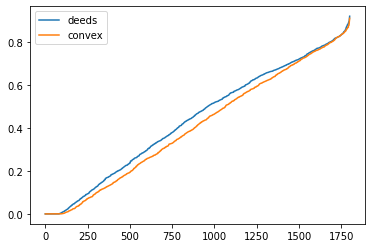

In [7]:
convex_atlases = torch.load("/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/20220318_crossmoda_convex_adam_lr/crossmoda_convex_registered_new_convex.pth")
deeds_atlases = torch.load("/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/20220114_crossmoda_multiple_registrations/crossmoda_deeds_registered.pth")

dcs_convex = []
for fixed_item in convex_atlases.values():
    for moving_item in fixed_item.values():
        dcs_convex.append(moving_item['dice'][0][1].item())
dcs_convex.sort()

dcs_deeds = []
for fixed_item in deeds_atlases.values():
    for moving_item in fixed_item.values():
        dcs_deeds.append(moving_item['dice'][0][1].item())
dcs_deeds.sort()

plt.plot(dcs_deeds, label='deeds')
plt.plot(dcs_convex, label='convex')
plt.legend()
plt.show()

# Create consensi (take training data directly and calculate consensi as well as dice values. Store data in a consistent dict)

### Pull out data of network training and put into fixed-moving dict

In [7]:
def calc_dp_consensus(lbl_list, weighting_list):
    LIMIT = .5
    label_stack = torch.stack(lbl_list)
    weightings = torch.tensor(weighting_list)
    weightings = torch.softmax(weightings, 0)
    weighted_stack = label_stack.to_dense()*weightings.view(-1,1,1,1)
    weighted_stack = weighted_stack.sum((0))
    consensus = (weighted_stack > LIMIT).long()
    # print()
    # print("")
    # plt.imshow(weighted_stack.sum((-1)))
    # plt.colorbar()
    # plt.show()

    # print()
    # print("Consensus W sum")
    # plt.imshow(consensus.sum((-1)))
    # plt.colorbar()
    # plt.show()

    return consensus


def calc_staple_consensus(lbl_list, weighting_list):
    staple_filter = sitk.STAPLEImageFilter()
    weightings = torch.tensor(weighting_list)
    weightings = torch.softmax(weightings, 0)
    # sitk.ProcessObject.SetGlobalDefaultDebugOff()
    FOREGROUND = 1.0
    staple_filter.SetForegroundValue(FOREGROUND)
    staple_filter.SetMaximumIterations(200)
    sitk_moving_data = [sitk.GetImageFromArray(lbl.to_dense().numpy().astype(np.int16)) for lbl in lbl_list]
    
    staple_out = staple_filter.Execute(sitk_moving_data)
    # staple_filter.SetConfidenceWeight(weightings.tolist())
    consensus = (torch.tensor(sitk.GetArrayFromImage(staple_out)) > .5).long()

    return consensus

def calc_jlf_consensus(sample_group, target_img_path):
    # see https://pubmed.ncbi.nlm.nih.gov/22732662/, Multi-Atlas Segmentation with Joint Label Fusion

    def standardize_img(img: ants.ANTsImage):
        # Image data is standardized with zero mean and unit variance, see paper p. 2
        data = img.numpy()
        data = data / np.std(data)
        data = data - data.mean()

        return img.new_image_like(data)

    target_img = nifti_to_ants(nib.load(target_img_path))
    target_img = standardize_img(target_img)

    target_mask = ants.get_mask(target_img)
    target_mask = ants.iMath(target_mask,'ME',2) # just to speed things up

    ants_image_list = []
    ants_seg_list = []

    for img_path, seg_path in zip(group.images, group.labels):
        # Build ants image list to feed it into jlf, \
        # loading nib first and converting to ants proved to be more stable compared to direct ants load
        cur_img = nifti_to_ants(nib.load(img_path))
        cur_seg = nifti_to_ants(nib.load(seg_path))

        # Copy header info since ants is picky with spatial tolerances
        # (could not find switch to increase tolerance setting)
        cur_seg.set_origin(target_img.origin)
        cur_img.set_origin(target_img.origin)
        cur_seg.set_spacing(target_img.spacing)
        cur_img.set_spacing(target_img.spacing)

        cur_img = standardize_img(cur_img)

        ants_image_list.append(cur_img)
        ants_seg_list.append(cur_seg)

    jlf_dict = joint_label_fusion(
        target_image=target_img,
        target_image_mask=target_mask,
        atlas_list=ants_image_list,
        beta=4,
        rad=2,
        label_list=ants_seg_list,
        rho=0.01,
        usecor=False,
        r_search=2,
        nonnegative=False,
        no_zeroes=False,
        max_lab_plus_one=True,
        output_prefix=None,
        verbose=True)

    # Write out jlf image data and segmentation numbers (json)
    for key, val in jlf_dict.items():
        if key == 'segmentation_numbers':
            seg_num_json_path = os.path.join(intermediate_dir, f"{group_prefix}_segmentation_numbers.json")
            with open(seg_num_json_path, 'w') as fil:
                json.dump(jlf_dict['segmentation_numbers'], fil)
        elif key in ['intensity', 'segmentation']:
            ants.image_write(jlf_dict[key], os.path.join(intermediate_dir,
                f"{group_prefix}_{key}.nii.gz"))
        elif key == 'probabilityimages':
            dict_keys_w_o_background = list(class_id_dict.keys())[1:]
            for prop_img, class_key in zip(val, dict_keys_w_o_background):
                ants.image_write(prop_img, os.path.join(intermediate_dir,
                    f"{group_prefix}_{key}_{class_key}.nii.gz"))


In [10]:
cases = ['400_deeds', '1200_deeds', '1800_deeds', '400_convex_adam']
current_case = cases[0]

print(f"Creating consensus for {current_case}")

if current_case == '400_deeds':
    # Training with 400 labels (deeds)
    network_scores = torch.load("/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/data/output/dashing-surf-1206_fold0_epx39/train_label_snapshot.pth")

elif current_case == '400_convex_adam':
    # Training with 400 labels (convex adam)
    network_scores = torch.load("/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/data/output/winter-frost-32_fold0_epx39/train_label_snapshot.pth")

elif current_case == '1200_deeds':
    network_scores = torch.load("/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/data/output/classic-sunset-1245_fold0_epx39/train_label_snapshot.pth")

elif current_case == '1800_deeds':
    network_scores = torch.load("/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/data/output/comic-sponge-1268_fold0_epx29/train_label_snapshot.pth")

data_paths = torch.load("/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/data/output/comic-sponge-1268_fold0_epx29/network_dataset_path_dict_train_1800.pth")


consensus_dicts = {}
d_ids = network_scores['d_ids']

print("Reading labels")
for _id in d_ids:
    network_data_lookup_idx = d_ids.index(_id)
    f_id = _id[:4]
    m_id = _id[6:]
    if f_id in consensus_dicts:
        fixed_dict = consensus_dicts.get(f_id)
    else:
        fixed_dict = {}
        #Only add expert label in first hit of fixed_dict
        fixed_dict['expert_label'] = network_scores['labels'][network_data_lookup_idx]
        fixed_dict['prediction'] = network_scores['train_predictions'][network_data_lookup_idx]
        fixed_dict['image_path'] = data_paths['train_image_paths'][_id]

    moving_dict = fixed_dict.get(m_id, {})
    moving_dict['warped_label'] = network_scores['modified_labels'][network_data_lookup_idx]
    moving_dict['data_parameter'] = network_scores['data_parameters'][network_data_lookup_idx]
    
    fixed_dict[m_id] = moving_dict
    
    consensus_dicts[f_id] = fixed_dict


print("Getting consensus scores")
dp_consensus_dices = []
staple_consensus_dices = []

print(consensus_dicts.keys())
for f_id, fixed_dict in tqdm(consensus_dicts.items()):
    # print(len(fixed_dict))
    lbls = []
    lbls = [elem['warped_label'] for elem in fixed_dict.values() if isinstance(elem, dict)]
    data_parameters = []
    data_parameters = [elem['data_parameter'] for elem in fixed_dict.values() if isinstance(elem, dict)]
    expert_label = fixed_dict['expert_label'].to_dense()
    # lbls.append(fixed_dict['prediction'].to_dense().squeeze().to_sparse())
    # data_parameters.append(max(data_parameters))
    # data_parameters.append(0.)

    dp_consensus = calc_dp_consensus(lbls, data_parameters)
    staaple_consensus = calc_staple_consensus(lbls, data_parameters)
    
    # print()
    # print("Expert label W sum")
    # plt.imshow(expert_label.float().mean((-1)))
    # plt.show()
    dp_dsc = dice3d(
        torch.nn.functional.one_hot(dp_consensus.unsqueeze(0), 2),
        torch.nn.functional.one_hot(expert_label.unsqueeze(0), 2),
        one_hot_torch_style=True, nan_for_unlabeled_target=False
    )
    staple_dsc = dice3d(
        torch.nn.functional.one_hot(staaple_consensus.unsqueeze(0), 2),
        torch.nn.functional.one_hot(expert_label.unsqueeze(0), 2),
        one_hot_torch_style=True, nan_for_unlabeled_target=False
    )
    print('f_id: ', f_id)
    print(f"DP consensus dice:", dp_dsc)
    print(f"STAPLE consensus dice:", staple_dsc)
    print()
    
    fixed_dict['dp_consensus'] = dp_consensus.to_sparse()
    fixed_dict['staple_consensus'] = staaple_consensus.to_sparse()
    
    fixed_dict['dp_consensus_oracle_dice'] = dp_dsc
    fixed_dict['staple_consensus_oracle_dice'] = staple_dsc

    consensus_dicts[f_id] = fixed_dict

torch.save(consensus_dicts, f"consensus_dict_{current_case}.pth")

Creating consensus for 400_deeds
Reading labels
Getting consensus scores
dict_keys(['147l', '143l', '146l', '192l', '149l', '177l', '178l', '175l', '140l', '188l', '183l', '152l', '202l', '141l', '189l', '200l', '205r', '162l', '145l', '199l', '158l', '179r', '187l', '190l', '204r', '165r', '167r', '174r', '185r', '166r', '164l', '198r', '209r', '195r', '181r', '171r', '168r', '180r', '173r', '210r'])


  0%|          | 0/40 [00:00<?, ?it/s]

f_id:  147l
DP consensus dice: tensor([[0.9990, 0.8031]])
STAPLE consensus dice: tensor([[0.9910, 0.3601]])

f_id:  143l
DP consensus dice: tensor([[0.9931, 0.6378]])
STAPLE consensus dice: tensor([[0.9930, 0.7607]])

f_id:  146l
DP consensus dice: tensor([[0.9904, 0.5717]])
STAPLE consensus dice: tensor([[0.9907, 0.6815]])

f_id:  192l
DP consensus dice: tensor([[0.9986, 0.7771]])
STAPLE consensus dice: tensor([[0.9962, 0.5997]])

f_id:  149l
DP consensus dice: tensor([[0.9953, 0.6715]])
STAPLE consensus dice: tensor([[0.9890, 0.5520]])

f_id:  177l
DP consensus dice: tensor([[0.9987, 0.8579]])
STAPLE consensus dice: tensor([[0.9982, 0.8231]])

f_id:  178l
DP consensus dice: tensor([[0.9935, 0.6933]])
STAPLE consensus dice: tensor([[0.9933, 0.6969]])

f_id:  175l
DP consensus dice: tensor([[0.9959, 0.6495]])
STAPLE consensus dice: tensor([[0.9954, 0.6867]])

f_id:  140l
DP consensus dice: tensor([[0.9987, 0.8034]])
STAPLE consensus dice: tensor([[0.9910, 0.4326]])

f_id:  188l
DP cons

In [16]:
def extract_consensus_dices(consensus_path):
    print(f"Extracting data from '{consensus_path}'")
    consensus_dicts = torch.load(consensus_path)
    dp_consensus_dices = []
    staple_consensus_dices = []

    for f_id, fixed_dict in consensus_dicts.items():
        dp_consensus_dices.append(fixed_dict['dp_consensus_oracle_dice'])
        staple_consensus_dices.append(fixed_dict['staple_consensus_oracle_dice']) 

    dp_tumour_dices = torch.cat(dp_consensus_dices)[:,1]
    staple_tumour_dices = torch.cat(staple_consensus_dices)[:,1]

    print(f"DP consensus mean dice: {dp_tumour_dices.mean().item():.3f}")
    print(f"STAPLE consensus mean dice: {staple_tumour_dices.mean().item():.3f}")
    print()
    return dp_tumour_dices, staple_tumour_dices

# Load consensus dices
consensus_dicts_convex_adam_path = "/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/20220323_consensus_convex_adam/consensus_dict_400_convex_adam.pth"
consensus_dicts_deeds_path = "/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/20220125_consensus/consensus_dict_400_deeds.pth"

dp_consensus_dices_deeds, staple_consensus_dices_deeds = extract_consensus_dices(consensus_dicts_deeds_path)
dp_consensus_dices_convex_adam, staple_consensus_dices_convex_adam = extract_consensus_dices(consensus_dicts_convex_adam_path)

Extracting data from '/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/20220125_consensus/consensus_dict_400_deeds.pth'
DP consensus mean dice: 0.654
STAPLE consensus mean dice: 0.581

Extracting data from '/share/data_supergrover1/weihsbach/shared_data/important_data_artifacts/curriculum_deeplab/20220323_consensus_convex_adam/consensus_dict_400_convex_adam.pth'
DP consensus mean dice: 0.616
STAPLE consensus mean dice: 0.568



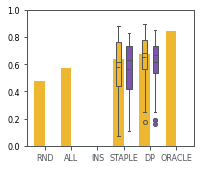

In [30]:
boxplot_data_deeds = [staple_consensus_dices_deeds.tolist(), dp_consensus_dices_deeds.tolist()]
boxplot_data_convex_adam = [staple_consensus_dices_convex_adam.tolist(), dp_consensus_dices_convex_adam.tolist()]
# df_deeds = pd.DataFrame(boxplot_data_deeds, index=['STAPLE consensus', 'DP consensus'])

hues = {
    'purple': (125/255, 84/255, 178/255),
    'red': (218/255, 76/255, 76/255),
    'yellow': (237/255, 183/255, 50/255),
    'green': (135/255, 206/255, 191/255),
    'gray': (161/255, 169/255, 173/255),
    'darkgray': (80/255, 85/255, 90/255),

}
LINE_WIDTH = 1
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 2.5))
lineprops = dict(color=hues['darkgray'], linewidth=LINE_WIDTH)
boxprops=dict(color=hues['darkgray'], linewidth=LINE_WIDTH)
flierprops = dict(marker='o', markerfacecolor=hues['darkgray'], markersize=4,
                  linestyle='none', markeredgecolor='none')
# rectangular box plot
bplot_deeds = ax.boxplot(boxplot_data_deeds,
                    widths = 0.2,
                    positions=[3-0.2, 4-0.2],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                    #  labels=['DP', 'STAPLE'], 
                     showmeans=True,
                     flierprops=flierprops, boxprops=boxprops,
                     whiskerprops=lineprops, capprops=lineprops,
                     meanline=True, medianprops=lineprops, meanprops=lineprops, 
                    #  showfliers=False
                     )

bplot_convex_adam = ax.boxplot(boxplot_data_convex_adam,
                    widths = 0.2,
                    positions=[3+0.2, 4+0.2],
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                    #  labels=['DP', 'STAPLE'], 
                     showmeans=True,
                     flierprops=flierprops, boxprops=boxprops,
                     whiskerprops=lineprops, capprops=lineprops,
                     meanline=True, medianprops=lineprops, meanprops=lineprops, 
                    #  showfliers=False
                     )

plt.rcParams.update({'font.size': 8})
ax.set_ylim([0.0,1.0])
# ax.set_xlim([-.1,0.3])

for box_patch, flier_patch, color in zip(bplot_deeds['boxes'], bplot_deeds['fliers'], [hues['yellow'], hues['yellow']]):
     box_patch.set_facecolor(color)
     flier_patch.set_markerfacecolor(color)
     flier_patch.set_markeredgecolor(hues['darkgray'])

for box_patch, flier_patch, color in zip(bplot_convex_adam['boxes'], bplot_convex_adam['fliers'], [hues['purple'], hues['purple']]):
     box_patch.set_facecolor(color)
     flier_patch.set_markerfacecolor(color)
     flier_patch.set_markeredgecolor(hues['darkgray'])
# ax.set_yticklabels([])
# ax.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     left=False,      # ticks along the bottom edge are off
#     right=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
ax.xaxis.set_tick_params(width=LINE_WIDTH)
ax.yaxis.set_tick_params(width=LINE_WIDTH, color=hues['darkgray'])
[x.set_linewidth(LINE_WIDTH) for x in ax.spines.values()]
[x.set_color(hues['darkgray']) for x in ax.spines.values()]
ax.tick_params(axis='x', colors=hues['darkgray'])
plt.bar([0-0.2, 1-0.2, 2-0.2, 3-0.2, 4-0.2, 5-0.2], [0.48,0.56928, -1, 0.636, .678, .844], color=hues['yellow'], width=0.4)
plt.bar([0+0.2, 1+0.2, 2+0.2, 3+0.2, 4+0.2, 5+0.2], [-1, -1, -1, -1, -1, -1], color=hues['purple'], width=0.4)
# plt.bar([0,1,2,3,4], [0.48,0.56928,0.636,.678,.844], color=hues['yellow'])
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(['RND', 'ALL', 'INS', 'STAPLE', 'DP', 'ORACLE'])
# plt.title('deeds registration', color=hues['darkgray'])
plt.savefig("box2.svg")